# data format
each training sample is going to be:
1 RGB image
16 joints coordinate of 2d

In [10]:
import os

import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms


class HandJointsPngAndCsvDataset(Dataset):
    def __init__(self, image_dir, joint_dir, image_size=(512, 512)):
        self.image_dir = image_dir
        self.joint_dir = joint_dir
        self.image_size = image_size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        label_file = image_file.replace(".png", "_joints2d.csv")
        label_path = os.path.join(self.joint_dir, label_file)

        img = Image.open(image_path).convert('RGB')
        img = self.transform(img)

        joint_df = pd.read_csv(label_path)
        coords = joint_df[['u', 'v']].values.astype(np.float32)
        coords /= self.image_size[0]

        return img, torch.tensor(coords)


# load the data

In [11]:
image_dir = '../../../scripts/auto_generator/ply2obj2img'
label_dir = '../../../scripts/auto_generator/ply2obj2img'

dataset = HandJointsPngAndCsvDataset(image_dir, label_dir)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

img, joints = dataset[0]
print(img.shape)
print(joints.shape)

torch.Size([3, 512, 512])
torch.Size([16, 2])


# define the model

In [12]:
class MyHandEstimator(nn.Module):
    def __init__(self, num_joints=16):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2, padding=2), # output 128*128
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), # output 64*64
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1), # output 32*32
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_joints * 2),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x.view(-1, 16, 2)


# training loop

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyHandEstimator().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for imgs, joints in dataloader:
        imgs = imgs.to(device)
        joints = joints.to(device)

        preds = model(imgs)
        loss = criterion(preds, joints)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{n_epochs}] Loss: {total_loss / len(dataloader):.6f}")

Epoch [1/30] Loss: 0.018525
Epoch [2/30] Loss: 0.000480
Epoch [3/30] Loss: 0.000510
Epoch [4/30] Loss: 0.000508
Epoch [5/30] Loss: 0.000524
Epoch [6/30] Loss: 0.000524
Epoch [7/30] Loss: 0.000549
Epoch [8/30] Loss: 0.000536
Epoch [9/30] Loss: 0.000525
Epoch [10/30] Loss: 0.000526
Epoch [11/30] Loss: 0.000517
Epoch [12/30] Loss: 0.000583
Epoch [13/30] Loss: 0.000541
Epoch [14/30] Loss: 0.000522
Epoch [15/30] Loss: 0.000527
Epoch [16/30] Loss: 0.000548
Epoch [17/30] Loss: 0.000603
Epoch [18/30] Loss: 0.000532
Epoch [19/30] Loss: 0.000553
Epoch [20/30] Loss: 0.000531
Epoch [21/30] Loss: 0.000543
Epoch [22/30] Loss: 0.000589
Epoch [23/30] Loss: 0.000535
Epoch [24/30] Loss: 0.000521
Epoch [25/30] Loss: 0.000533
Epoch [26/30] Loss: 0.000528
Epoch [27/30] Loss: 0.000520
Epoch [28/30] Loss: 0.000537
Epoch [29/30] Loss: 0.000595
Epoch [30/30] Loss: 0.000566


# visualize predicted vs label

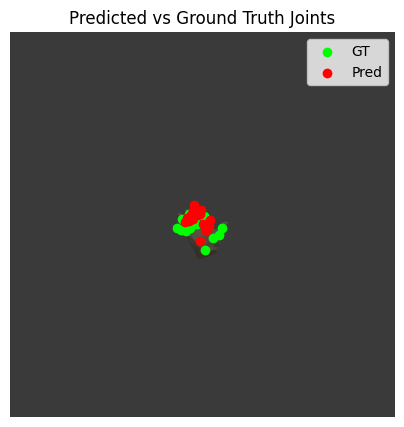

In [14]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    img_tensor, gt = dataset[0]
    input_tensor = img_tensor.unsqueeze(0).to(device)  # add batch dim
    pred = model(input_tensor).cpu()[0].numpy()        # shape: (16, 2)

gt_pixels = gt.numpy() * 512
pred_pixels = pred * 512

plt.figure(figsize=(5, 5))
plt.imshow(img_tensor.permute(1, 2, 0))  # convert (C, H, W) → (H, W, C)
plt.scatter(gt_pixels[:, 0], gt_pixels[:, 1], c='lime', label='GT')
plt.scatter(pred_pixels[:, 0], pred_pixels[:, 1], c='red', label='Pred')
plt.legend()
plt.title("Predicted vs Ground Truth Joints")
plt.axis('off')
plt.show()